In [1]:
import pandas as pd
from pathlib import Path

import sys
from pathlib import Path

# Add src/ to sys.path
project_root = Path().resolve().parent  # assumes you're in notebooks/
src_path = project_root / "src"
sys.path.append(str(src_path))

df = pd.read_csv(project_root / "data" / "processed" / "fusion_features.csv")  # your merged set

# Confirm user distribution
print(df["user"].value_counts())


user
user3    411
user2    403
user1    369
Name: count, dtype: int64


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from wearable_htad.evaluation.metrics import evaluate_model

def numeric_only(df):
    """Return numeric columns only, replacing infs/NAs safely."""
    import numpy as np
    return (
        df.select_dtypes(include=[np.number])
          .replace([np.inf, -np.inf], np.nan)
          .fillna(0.0)
    )


users = df["user"].unique()
results_RF = []


for test_user in users:
    print(f"🔁 Leaving out: {test_user}")

    # Split data
    df_train = df[df["user"] != test_user]
    df_test = df[df["user"] == test_user]

    # Feature selection
    #feature_cols = [c for c in df.columns if c.startswith("v1_") or c.startswith(("x_", "y_", "z_", "sma"))]
    X_train = numeric_only(df_train)
    y_train = df_train["activity"]

    X_test = numeric_only(df_test)
    y_test = df_test["activity"]

    # Model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    result = evaluate_model(y_test, y_pred, name=f"LOUO: {test_user}")
    results_RF.append(result)


🔁 Leaving out: user1
🔁 Leaving out: user2
🔁 Leaving out: user3


In [26]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

CONF_DIR = Path("outputs/confusion")

def _ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

def save_confusion_png(cm: np.ndarray, labels: list[str], title: str, out_png: Path) -> None:
    """Save a confusion matrix as a PNG (counts or normalized)."""
    _ensure_dir(out_png.parent)
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    # annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}" if cm.max()<=1.0 else int(cm[i, j]),
                    ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(out_png, dpi=160)
    plt.close(fig)

def save_confusion_csv(cm: np.ndarray, labels: list[str], out_csv: Path) -> None:
    _ensure_dir(out_csv.parent)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    df_cm.to_csv(out_csv)

def save_classification_report(y_true: pd.Series, y_pred: np.ndarray, labels: list[str], out_csv: Path) -> None:
    """Save per-class precision/recall/F1 as CSV."""
    _ensure_dir(out_csv.parent)
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    pd.DataFrame(report).to_csv(out_csv)

def compute_matrices(y_true: pd.Series, y_pred: np.ndarray, labels: list[str]) -> tuple[np.ndarray, np.ndarray]:
    """Return (counts_cm, row_normalized_cm)."""
    cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm_counts.sum(axis=1, keepdims=True)
        cm_norm = np.divide(cm_counts, row_sums, out=np.zeros_like(cm_counts, dtype=float), where=row_sums>0)
    return cm_counts, cm_norm


In [27]:
from __future__ import annotations

import time
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

# Optional: LightGBM (comment out if not installed)
from lightgbm import LGBMClassifier


# ---------- 1) One place to define labels/meta/numeric features ----------
LABEL_COL = "activity"
GROUP_COL = "user"
META_COLS = {"row_id", "start_idx", "start_time", "sensor", "source_file", GROUP_COL, LABEL_COL}

def get_feature_cols(df: pd.DataFrame) -> list[str]:
    """Numeric feature columns only, excluding metadata."""
    return [
        c for c in df.columns
        if c not in META_COLS and np.issubdtype(df[c].dtype, np.number)
    ]


# ---------- 2) Reusable model pipelines ----------
def make_rf_pipeline() -> Pipeline:
    # Trees don’t need scaling, but imputation is a good hygiene step.
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )),
    ])

def make_lgbm_pipeline(num_classes: int) -> Pipeline:
    # Scaling can help LightGBM histogram binning on mixed-scale features.
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LGBMClassifier(
            objective="multiclass",
            num_class=num_classes,
            n_estimators=800,
            learning_rate=0.1,
            num_leaves=128,
            feature_fraction=0.7,
            bagging_fraction=0.8,
            bagging_freq=5,
            min_data_in_leaf=20,
            lambda_l1=1.0,
            lambda_l2=1.0,
            n_jobs=-1,
            random_state=42,
            verbose=-1,
        )),
    ])


# ---------- 3) LOUO runner (works for any sklearn pipeline) ----------
def run_louo(df: pd.DataFrame, pipeline: Pipeline, model_name: str, save_conf: bool = True) -> pd.DataFrame:
    users = df[GROUP_COL].astype(str).unique()
    feat_cols = get_feature_cols(df)
    class_order = sorted(df[LABEL_COL].astype(str).unique())

    rows = []
    # collectors for overall cm
    cm_total_counts = np.zeros((len(class_order), len(class_order)), dtype=int)

    t0 = time.time()
    for u in users:
        print(f"🔁 Leaving out: {u}")
        train = df[df[GROUP_COL] != u]
        test  = df[df[GROUP_COL] == u]

        X_tr = train[feat_cols].replace([np.inf, -np.inf], np.nan)
        X_te = test[feat_cols].reindex(columns=feat_cols).replace([np.inf, -np.inf], np.nan)

        y_tr = train[LABEL_COL].astype(str)
        y_te = test[LABEL_COL].astype(str)

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_te)

        rows.append({
            "Model": f"LOUO: {u}",
            "Accuracy": accuracy_score(y_te, y_pred),
            "F1 Macro": f1_score(y_te, y_pred, average="macro"),
            "F1 Weighted": f1_score(y_te, y_pred, average="weighted"),
        })
        # confusion matrices
        cm_counts, cm_norm = compute_matrices(y_te, y_pred, class_order)
        cm_total_counts += cm_counts

        if save_conf:
            base = CONF_DIR / model_name / f"user={u}"
            save_confusion_csv(cm_counts, class_order, base.with_suffix(".counts.csv"))
            save_confusion_csv(cm_norm,   class_order, base.with_suffix(".norm.csv"))
            save_confusion_png(cm_counts, class_order, f"{model_name} — {u} (counts)", base.with_suffix(".counts.png"))
            save_confusion_png(cm_norm,   class_order, f"{model_name} — {u} (row-normalized)", base.with_suffix(".norm.png"))
            save_classification_report(y_te, y_pred, class_order, base.with_suffix(".report.csv"))


    out = pd.DataFrame(rows)
    print(f"⏱️ Done {model_name} in {time.time() - t0:.1f}s")
    return out


# ---------- 4) Usage ----------
# df: your fused dataset (audio + accel) with 'activity' and 'user' present
feature_cols = get_feature_cols(df)
assert len(feature_cols) > 0, "No numeric feature columns found after excluding metadata."

# Random Forest
rf_results = run_louo(df, make_rf_pipeline(), model_name="RandomForest")
print(rf_results)

# LightGBM (uncomment if using LightGBM)
lgbm_results = run_louo(df, make_lgbm_pipeline(num_classes=df[LABEL_COL].nunique()), model_name="LightGBM")
print(lgbm_results)

# Optional: side-by-side compare
def tidy_with_tag(res: pd.DataFrame, tag: str) -> pd.DataFrame:
    r = res.copy()
    r.insert(0, "ModelName", tag)
    return r

all_results = pd.concat([
    tidy_with_tag(rf_results, "RF"),
    tidy_with_tag(lgbm_results, "LGBM")
], ignore_index=True)
print(all_results)


🔁 Leaving out: user1
🔁 Leaving out: user2
🔁 Leaving out: user3
⏱️ Done RandomForest in 1.3s
         Model  Accuracy  F1 Macro  F1 Weighted
0  LOUO: user1  0.707317  0.668254     0.720395
1  LOUO: user2  0.583127  0.573237     0.583032
2  LOUO: user3  0.610706  0.576025     0.579551
🔁 Leaving out: user1


/Users/johanneskeisers/Documents/GitHub/wearable-activity-htad/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔁 Leaving out: user2


/Users/johanneskeisers/Documents/GitHub/wearable-activity-htad/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔁 Leaving out: user3
⏱️ Done LightGBM in 1.5s
         Model  Accuracy  F1 Macro  F1 Weighted
0  LOUO: user1  0.691057  0.662688     0.699826
1  LOUO: user2  0.528536  0.519322     0.521966
2  LOUO: user3  0.627737  0.602341     0.605610
  ModelName        Model  Accuracy  F1 Macro  F1 Weighted
0        RF  LOUO: user1  0.707317  0.668254     0.720395
1        RF  LOUO: user2  0.583127  0.573237     0.583032
2        RF  LOUO: user3  0.610706  0.576025     0.579551
3      LGBM  LOUO: user1  0.691057  0.662688     0.699826
4      LGBM  LOUO: user2  0.528536  0.519322     0.521966
5      LGBM  LOUO: user3  0.627737  0.602341     0.605610


/Users/johanneskeisers/Documents/GitHub/wearable-activity-htad/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [28]:
results_RF

[{'Model': 'LOUO: user1',
  'Accuracy': 0.6504065040650406,
  'F1 Macro': 0.601601095464285,
  'F1 Weighted': 0.6662156998278663},
 {'Model': 'LOUO: user2',
  'Accuracy': 0.5856079404466501,
  'F1 Macro': 0.5824725806915184,
  'F1 Weighted': 0.5858172336738804},
 {'Model': 'LOUO: user3',
  'Accuracy': 0.610705596107056,
  'F1 Macro': 0.5510119895609867,
  'F1 Weighted': 0.5544388314095288}]

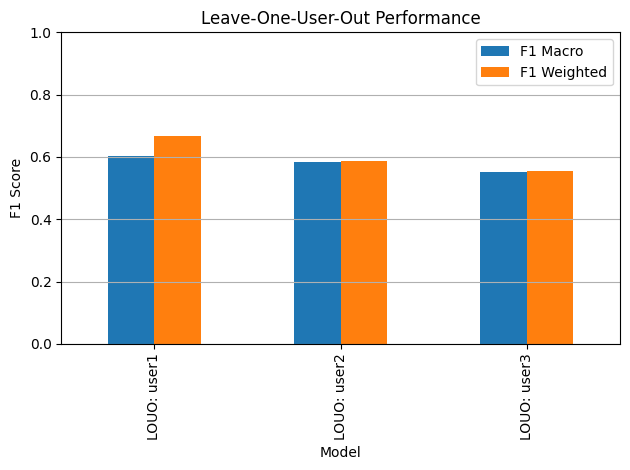

In [18]:
import matplotlib.pyplot as plt

results_RF_df.set_index("Model")[["F1 Macro", "F1 Weighted"]].plot(kind="bar", ylim=(0,1))
plt.title("Leave-One-User-Out Performance")
plt.ylabel("F1 Score")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


In [20]:
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from wearable_htad.evaluation.metrics import evaluate_model

def numeric_only(df):
    """Return numeric columns only, replacing infs/NAs safely."""
    import numpy as np
    return (
        df.select_dtypes(include=[np.number])
          .replace([np.inf, -np.inf], np.nan)
          .fillna(0.0)
    )


users = df["user"].unique()
results = []



for test_user in users:
    print(f"🔁 Leaving out: {test_user}")

    scaler = StandardScaler()


    # Split data
    df_train = df[df["user"] != test_user]
    df_test  = df[df["user"] == test_user]

    X_train = numeric_only(df_train)
    X_train = X_train.drop(columns=["start_idx", "start_time"], errors="ignore")
    X_train = scaler.fit_transform(X_train)
    y_train = df_train["activity"]

    X_test  = numeric_only(df_test)
    X_test  = X_test.drop(columns=["start_idx", "start_time"], errors="ignore")
    X_test = scaler.transform(X_test)
    y_test  = df_test["activity"]

    # LightGBM classifier (via scikit-learn wrapper)
    from lightgbm import LGBMClassifier
    model = LGBMClassifier(
        objective="multiclass",
        num_class=len(y_train.unique()),
        n_estimators=800,
        learning_rate=0.1,
        num_leaves=128,
        feature_fraction=0.7,
        bagging_fraction=0.8,
        bagging_freq=5,
        min_data_in_leaf=10,
        random_state=42,
        n_jobs=-1
    )

    pipeline = Pipeline([
        ("scaler", StandardScaler()),  # optional; not harmful for LightGBM
        ("clf", model)
    ])

    # Train + predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate
    result = evaluate_model(y_test, y_pred, name=f"LOUO: {test_user}")
    results.append(result)


🔁 Leaving out: user1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-w

/Users/johanneskeisers/Documents/GitHub/wearable-activity-htad/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
🔁 Leaving out: user2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is 

/Users/johanneskeisers/Documents/GitHub/wearable-activity-htad/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/johanneskeisers/Documents/GitHub/wearable-activity-htad/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1 Macro,F1 Weighted
0,LOUO: user1,0.772358,0.735134,0.778414
1,LOUO: user2,0.516129,0.505973,0.509129
2,LOUO: user3,0.654501,0.627798,0.631238


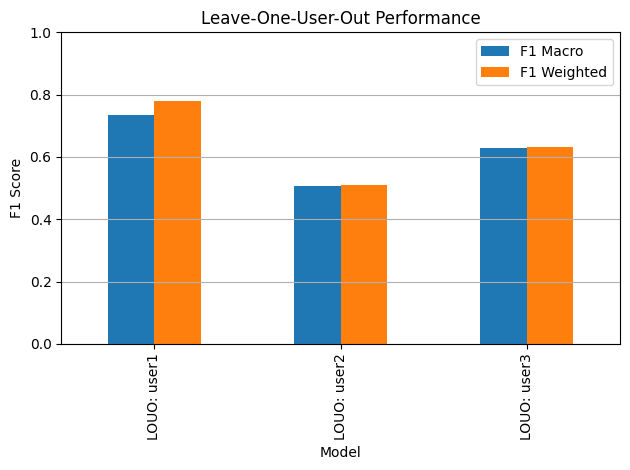

In [22]:
import matplotlib.pyplot as plt

results_df.set_index("Model")[["F1 Macro", "F1 Weighted"]].plot(kind="bar", ylim=(0,1))
plt.title("Leave-One-User-Out Performance")
plt.ylabel("F1 Score")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mats = {}

